In [1]:
import numpy as np
import random 
from matplotlib import pyplot as plt

### BettingMarket class

In [2]:
class BettingMarket: 
    def __init__(self, n, init_quant, msr_type, alpha, beta, true_dist):
        self.n = n
        self.q = init_quant # a list of length n
        self.msr = msr_type # a string representing type market scoring rule
        self.alpha = alpha  # the constant alpha for LS-LMSR
        self.beta = beta    # the constant beta for LMSR
        
        self.true_dist = true_dist # a "ground truth" probability distribution from which to draw the result 
        self.outcome = None 

        self.traders = []
        self.init_q = init_quant 
        self.init_cost = self.cost(self.q)
        # self.revenue = -self.init_cost
        

    def cost_LMSR(self, beta, q):
        return beta*np.log(np.sum(np.exp(np.array(q)/beta)))
    # TBD: DEAL WITH OVERFLOW IN EXP

    def cost(self, q):
        if self.msr == "LMSR":
            return self.cost_LMSR(self.beta, q)
        else: # want "LS_LMSR"
            b = self.alpha*np.sum(q)
            return self.cost_LMSR(b, q)
    
    def get_price_vector(self, q):
        return [self.get_price(i, q) for i in range(len(q))]

    def get_price_prob(self, q):
        price_vec = self.get_price_vector(q)
        return np.array(price_vec)/np.sum(price_vec)
    
    def get_price(self, i, q):
        if self.msr == "LMSR":
            return np.exp(q[i]/self.beta)/np.sum(np.exp(np.array(q)/self.beta))
        else: # "LS-LMSR"
            b = self.alpha*sum(q)
            sum_term = np.sum(np.exp(np.array(q)/b))
            term1 = self.alpha * np.log(sum_term)
            term2_num = (np.sum(q)*np.exp(q[i]/b) - np.sum([x*np.exp(x/b) for x in q]))
            term2_denom = np.sum(q)*sum_term
            return term1 + term2_num/term2_denom

    def submit_bet(self, trader, delta, verbose=False):
        new_q = [sum(x) for x in zip(self.q, delta)]
        curr_cost = self.cost(self.q)
        new_cost = self.cost(new_q)
        if(new_cost-curr_cost > trader.money):
            if verbose:
                print("Insufficient trader funds: trader money={m}, transaction cost={c}".format(m=trader.money, c=new_cost-curr_cost))
            return None
        self.q = new_q
        trader.money -= (new_cost-curr_cost)
        trader.payouts = [sum(x) for x in zip(trader.payouts, delta)]

        if verbose:
            print("Trader", trader.id, "updates to", self.q, "for cost of", (new_cost-curr_cost))
        return new_cost - curr_cost
    
    def get_revenue(self, outcome):
        # LOSS / REVENUE FUNCTION: current definition is C(q)-C(q0)-z_i, where z_i is the PAYOUT for the outcome i (not total quantity_i)
        return self.cost(self.q)-self.init_cost-(self.q[outcome]-self.init_q[outcome])
        # return self.cost(self.q)-self.init_cost-self.q[outcome]
    
    def get_expected_revenue(self):
        revs = [self.get_revenue(i) for i in range(len(self.q))]
        return np.dot(self.get_price_prob(self.q), np.array(revs))
    
    def get_market_state(self, silence=False):
        if self.outcome is None: # draw the outcome the first time this is called
            self.outcome = random.choices(list(range(self.n)), weights=self.true_dist)[0]
        
        revenue = self.get_revenue(self.outcome)
        if not silence:
            print("State:", self.q)
            print("Final instantaneous prices:", [self.get_price(0, self.q), self.get_price(1, self.q)])
            print("Outcome realized:", self.outcome)
            print("Revenue:", revenue)

# TBD: IMPLEMENT "MOVE FORWARD IN OBLIGATION SPACE" requirement

### Trader class

In [3]:
class Trader:
    def __init__(self, id, n, init_money):
        self.n = n
        self.id = id
        self.money = init_money
        self.payouts = [0]*n
    
    def set_belief(self, prob_vector):
        self.belief = prob_vector
    
    def bet(self, mkt: BettingMarket, i, amt, verbose=False):
        delta = [(1 if i==j else 0)*amt for j in range(self.n)]
        return mkt.submit_bet(self, delta, verbose)

    def play(self, mkt: BettingMarket, DELTA_FRAC=0.002, MAX_ITER=2/0.002, verbose=False):
        '''
         Makes bet for this Trader's turn by buying each asset while its price is less than probability distribution belief
           if Trader can afford the bet
         DELTA_FRAC: fraction of market to buy in each evaluation (in each delta/step) of price vs belief -- sets discretizing error
         MAX_ITER: sets maximum number of times for evaluating the price/probability and betting DELTA_FRAC of market
        '''
        # Q: could this infinite loop? do we really need MAX_ITER or not? 
        flag=True
        init_cost = mkt.cost(mkt.q)
        init_payouts = self.payouts

        bet_cost = True
        if(mkt.get_price(0, mkt.q) < self.belief[0]):
            while(MAX_ITER >= 0 and mkt.get_price(0, mkt.q) < self.belief[0] and bet_cost is not None):
                bet_cost = self.bet(mkt, 0, DELTA_FRAC*mkt.q[0])
                MAX_ITER-=1
        elif(mkt.get_price(1, mkt.q) < self.belief[1]):   
            while(MAX_ITER >= 0 and mkt.get_price(1, mkt.q) < self.belief[1] and bet_cost is not None):
                bet_cost = self.bet(mkt, 1, DELTA_FRAC*mkt.q[1])
                MAX_ITER-=1

        # while(flag and MAX_ITER >= 0):
        #     flag = False
        #     # this is hard-coded for a 2-item market
        #     if(mkt.get_price(0, mkt.q) < self.belief[0]):
        #         flag=True
        #         bet_cost = self.bet(mkt, 0, DELTA_FRAC*mkt.q[0])
        #         if bet_cost is None: 
        #             flag=False
        #     elif(mkt.get_price(1, mkt.q) < self.belief[1]):
        #         bet_cost = self.bet(mkt, 1, DELTA_FRAC*mkt.q[1])
        #         if bet_cost is not None: 
        #             flag=True # logic: set flag to True if this went through, otherwise leave whatever was from first item
        #     MAX_ITER-=1

        if(MAX_ITER < 0):
            print("LOG: play() function hit MAX_ITER")
        
        final_cost = mkt.cost(mkt.q)
        if(verbose):
            print("Cost of transaction", final_cost-init_cost)
            print("Expected final return after transaction", sum(self.belief[i]*self.payouts[i] for i in range(self.n)))
            print("Current price vs beliefs", [mkt.get_price(0, mkt.q), mkt.get_price(1, mkt.q)], self.belief)

        bet = [x[0]-x[1] for x in zip(self.payouts, init_payouts)]
        return bet, final_cost-init_cost

### Simulation class

In [4]:
class Simulation:

    def __init__(self):
        self.betters = []
    
    # def add_better(self, trader: Trader):
    #     self.betters.append(trader)

    def draw_unif_ground_truth(self, low, high):
        p0 = low+(high-low)*random.random()
        return [p0, 1-p0]

    def create_market_comp(self, init_quant, msr1, msr2, msr1_const, msr2_const, ground_truth):
        b1 = BettingMarket(2, init_quant, msr1, (None if msr1 == "LMSR" else msr1_const), (None if msr1 == "LS-LMSR" else msr1_const), ground_truth)
        b2 = BettingMarket(2, init_quant, msr2, (None if msr2 == "LMSR" else msr2_const), (None if msr2 == "LS-LMSR" else msr2_const), ground_truth)
        return [b1, b2]

    def compute_b(self, alpha, init_quant):
        lslmsr =  BettingMarket(2, init_quant, "LSLMSR", alpha, None, [-1, -1])
        worst_case_loss = lslmsr.init_cost # worst-case LS-LMSR loss is just C(q0)
        # worst-case LMSR loss is -b ln (exp(q0_i /b) / sum(exp(q0_j / b))), where q0_i is the max value in init_quant
        #   (this formula reduces to b ln(n) for uniform initial distribution; TBD: check that correct for general case)
        uniform_flag = True
        for x in init_quant:
            if not x == init_quant[0]:
                uniform_flag = False
                break
        assert(uniform_flag)
        b = worst_case_loss / np.log(2)
        return b, worst_case_loss
    
    def perfect_trader_sim(self, ntraders, trader_money, markets, silence=False, verbose=False):
        b1, b2 = markets[0], markets[1]
        assert(b1.true_dist == b2.true_dist)
       
        if not silence:
            print()
            print()
            print('GROUND TRUTH:', b1.true_dist)
            print('INITIAL PRICE: LMSR', [b1.get_price_vector(b1.q)])
            print('INITIAL PRICE: LS-LMSR', [b2.get_price_vector(b2.q)])
            print()

        traders_b1 = []
        bets_b1 = []
        costs_b1 = []
        traders_b2 = []
        bets_b2 = []
        costs_b2 = []

        for i in range(ntraders):
            traderv1 = Trader(i, 2, trader_money)
            traderv1.set_belief(b1.true_dist)
            traders_b1.append(traderv1)
            traderv2 = Trader(i, 2, trader_money)
            traderv2.set_belief(b1.true_dist)
            traders_b2.append(traderv2)
            
            if not silence:
                print("LMSR market trader", i, ":")
            bet1, cost1 = traderv1.play(b1, verbose=verbose)
            bets_b1.append(bet1)
            costs_b1.append(cost1)
            if not silence:
                print("Final: bet:", bet1, "cost:", cost1)
                print('------')

                print("LS-LMSR market trader", i, ":")
            bet2, cost2 = traderv2.play(b2, verbose=verbose)
            bets_b2.append(bet2)
            costs_b2.append(cost2)
            if not silence:
                print("Final: bet:", bet2, "cost:", cost2)
                print()
        if not silence:
            print('==========')
            print('LMSR market: ')
        b1.get_market_state(silence=silence)
        if not silence:
            print()
            print('LS-LMSR market')
        b2.get_market_state(silence=silence)

        return (b1.get_price_vector(b1.q), b2.get_price_vector(b2.q), b1.get_revenue(b1.outcome), b2.get_revenue(b2.outcome)) # change this to same outcome?
    
    def noisyinfo_sim(self, ntraders, trader_money, markets, priv_info_noise=0.2, p_signal_low=0.5, p_signal_high=0.5, silence=False, verbose=False):
        '''
        !! DEPRECATED: NOT USING THIS ANYMORE !!
        Parameters:
         - priv_info_noise: private info will be uniform in [ground_truth-priv_info_noise, ground_truth+priv_info_noise]
             (Note: for intended simulation, this should be pretty noisy!)
         - p_signal: probability with which any given trader will consider the current market value too 
        '''
        ## TBD: MODELING CHANGES ## 
        #  - add shifting ground truth for market? #
        #  - [DONE] make p_signal vary in time? # 

        b1, b2 = markets[0], markets[1]
        assert(b1.true_dist == b2.true_dist)
        if not silence:
            print()
            print()
            print('GROUND TRUTH:', b1.true_dist)
            print('priv_info_noise:', priv_info_noise, '; p_signal_low:', p_signal_low, '; p_signal_high:', p_signal_high)
            print('INITIAL PRICE: LMSR', [b1.get_price_vector(b1.q)])
            print('INITIAL PRICE: LS-LMSR', [b2.get_price_vector(b2.q)])
            print()
        
        traders_b1 = []
        bets_b1 = []
        costs_b1 = []
        traders_b2 = []
        bets_b2 = []
        costs_b2 = []

        for i in range(ntraders):
            traderv1 = Trader(i, 2, trader_money)
            traders_b1.append(traderv1)
            traderv2 = Trader(i, 2, trader_money)
            traders_b2.append(traderv2)
            # MAIN: Set this trader's belief
            # 1. some private info distributed noisily around ground truth (want this to be pretty noisy?)
            priv_info = min(random.random()*(2*priv_info_noise)+max(b1.true_dist[0]-priv_info_noise, 0.001), 0.999)
            trad_b1_p0 = priv_info
            trad_b2_p0 = priv_info
            # 2. with p_signal probability, update to be between this and current market value price-probability 
            p_signal = ((i+1)/ntraders)*(p_signal_high - p_signal_low) + p_signal_low # idea: increases from p_signal_low to p_signal_high over time
            # ^^ possible issue: high p_signal by the end regardless of ntraders, if compute as fraction of ntraders
            if(random.random() >= p_signal):
                trad_b1_p0 += min(0.999, max(0.001, random.random()*(b1.get_price_prob(b1.q)[0]-priv_info)))
                trad_b2_p0 += min(0.999, max(0.001, random.random()*(b2.get_price_prob(b2.q)[0]-priv_info)))
                ## NEW MODEL: sample between current market belief and true market belief
                # trad_b1_p0 = min(0.999, max(0.001, random.random()*(b1.get_price_prob(b1.q)[0]-b1.true_dist[0])+b1.true_dist[0]))
                # trad_b2_p0 = min(0.999, max(0.001, random.random()*(b2.get_price_prob(b2.q)[0]-b2.true_dist[0])+b2.true_dist[0]))
            traderv1.set_belief([trad_b1_p0, 1-trad_b1_p0])
            traderv2.set_belief([trad_b2_p0, 1-trad_b2_p0])

            if not silence:
                print("LMSR market trader", i, ":")
            bet1, cost1 = traderv1.play(b1, verbose=verbose)
            bets_b1.append(bet1)
            costs_b1.append(cost1)
            if not silence:
                print("Final: bet:", bet1, "cost:", cost1)
                print('------')

                print("LS-LMSR market trader", i, ":")
            bet2, cost2 = traderv2.play(b2, verbose=verbose)
            bets_b2.append(bet2)
            costs_b2.append(cost2)
            if not silence:
                print("Final: bet:", bet2, "cost:", cost2)
                print()

        if not silence:
            print('==========')
            print('LMSR market: ')
        b1.get_market_state(silence=silence)
        if not silence:
            print()
            print('LS-LMSR market')
        b2.get_market_state(silence=silence)

        return (b1.get_price_prob(b1.q), b2.get_price_prob(b2.q), b1.get_expected_revenue(), b2.get_expected_revenue())

    def simple_noise_sim(self, ntraders, trader_money, markets, priv_info_noise=0.2, look_back = 50, k=0.5, k_min=None, k_max=None, silence=False, verbose=False):
        '''
        Idea: at each time instant (for each trader), 
          (1) draw some (noisy) private info
          (2) use average of last look_back market prices 
          (3) trader belief is a weighted average (weighted by k) of market average and private info 
        Parameters:
         - priv_info_noise: private info will be uniform in [ground_truth-priv_info_noise, ground_truth+priv_info_noise]
             (Note: for intended simulation, this should be pretty noisy!)
         - look_back: number of previous market price beliefs to consider 
         - k: weight for weighted average belief (OR: k_min --> k_max)
        '''
        b1, b2 = markets[0], markets[1]
        assert(b1.true_dist == b2.true_dist)
       
        if not silence:
            print()
            print()
            print('GROUND TRUTH:', b1.true_dist)
            print('priv_info_noise:', priv_info_noise, '; look_back:', look_back, '; k:', k)
            print('INITIAL PRICE: LMSR', [b1.get_price_vector(b1.q)])
            print('INITIAL PRICE: LS-LMSR', [b2.get_price_vector(b2.q)])
            print()
        
        traders_b1 = []
        bets_b1 = []
        costs_b1 = []
        traders_b2 = []
        bets_b2 = []
        costs_b2 = []
        prev_b1market_p0 = []
        prev_b2market_p0 = []

        for i in range(ntraders):
            traderv1 = Trader(i, 2, trader_money)
            traders_b1.append(traderv1)
            traderv2 = Trader(i, 2, trader_money)
            traders_b2.append(traderv2)

            prev_b1market_p0.append(b1.get_price_prob(b1.q)[0])
            prev_b2market_p0.append(b2.get_price_prob(b2.q)[0])

            # MAIN: Set this trader i's belief: lambda*(priv_info) + (1-lambda)*(market_avg_till_now, up to look_back)
            # 1. some private info distributed noisily around ground truth (want this to be pretty noisy?)
            #  [TBD: determine what distribution should private info be drawn from]
            priv_info = min(random.random()*(2*priv_info_noise)+max(b1.true_dist[0]-priv_info_noise, 0.001), 0.999)
            trad_b1_p0, trad_b2_p0 = priv_info, priv_info
            # 2. compute average of look_back previous market values
            b1avg, b2avg  = np.mean(prev_b1market_p0[-1*min(look_back, i+1):]), np.mean(prev_b2market_p0[-1*min(look_back, i+1):])
            # 3. weight previous market prob values with private info based on k: k*(MY INFO)+(1-k)*(MARKET AVG)
            #      with possibility for using a k linearly varying from **k_max to k_min** (NOTE DIRECTION!) across ntraders
            #       e.g. 1st trader uses k=k_max=0.8 (rely on private info), final trader uses k=k_min=0.2 (rely on market avg)
            k = ((k_max+(k_min-k_max)*(i+1)/ntraders) if k_min is not None else k)
            # note: variable k does NOT seem to work great for increasing accuracy trend -- does lead to BETTER MM revenue? somehow?
            trad_b1_p0 = k*trad_b1_p0 + (1-k)*b1avg
            trad_b2_p0 = k*trad_b2_p0 + (1-k)*b2avg 

            traderv1.set_belief([trad_b1_p0, 1-trad_b1_p0])
            traderv2.set_belief([trad_b2_p0, 1-trad_b2_p0])
            if not silence:
                print("LMSR market trader", i, ":")
            bet1, cost1 = traderv1.play(b1, verbose=verbose)
            bets_b1.append(bet1)
            costs_b1.append(cost1)
            if not silence:
                print("Final: bet:", bet1, "cost:", cost1)
                print('------')

                print("LS-LMSR market trader", i, ":")
            bet2, cost2 = traderv2.play(b2, verbose=verbose)
            bets_b2.append(bet2)
            costs_b2.append(cost2)
            if not silence:
                print("Final: bet:", bet2, "cost:", cost2)
                print()
        if not silence:
            print('==========')
            print('LMSR market: ')
        b1.get_market_state(silence=silence)
        if not silence:
            print()
            print('LS-LMSR market')
        b2.get_market_state(silence=silence)

        return (b1.get_price_prob(b1.q), b2.get_price_prob(b2.q), b1.get_expected_revenue(), b2.get_expected_revenue())


### Perfect information: run various simulations (different parameters) 

In [5]:
vigs = np.arange(0.02, 0.2, 0.01)
alphas = vigs/(2*np.log(2))

init_quant = [100, 100]
N_TRIALS = 100
N_TRADERS = 10

acc_LS = []
acc_LMSR = []
rev_LS = []
rev_LMSR = []
rev_stdevs_LMSR = []
rev_stdevs_LS = []

exprev_LMSR = []
exprev_LS = []
exprev_stdevs_LMSR = []
exprev_stdevs_LS = []

wcls= []

for alpha in alphas:
    s = Simulation()
    acc_LS_temp = []
    acc_LMSR_temp = []
    rev_LS_temp = []
    rev_LMSR_temp = []
    exprev_LMSR_temp = []
    exprev_LS_temp = []

    b, worst_case_loss = s.compute_b(alpha, init_quant)
    # print(b, worst_case_loss)
    wcls.append(-worst_case_loss)

    for i in range(N_TRIALS):
        ground_truth = s.draw_unif_ground_truth(0.7, 0.9)
        markets = s.create_market_comp([100, 100], 'LMSR', 'LSLMSR', b, alpha, ground_truth)
        b1, b2 = markets[0], markets[1]
        b1_price, b2_price, b1_rev, b2_rev = s.perfect_trader_sim(N_TRADERS, 100000000, markets, silence=True)
        # print(b1.init_cost, b1.cost(b1.q), b1.q[b1.outcome], worst_case_loss)

        # normalize prices (specifically for b2)
        b1_price = np.array(b1_price)/np.sum(b1_price)
        b2_price = np.array(b2_price)/np.sum(b2_price)

        acc_LS_temp.append(1-abs(b2_price[0]-ground_truth[0]))
        acc_LMSR_temp.append(1-abs(b1_price[0]-ground_truth[0]))
        rev_LS_temp.append(b2_rev)
        rev_LMSR_temp.append(b1_rev)
        exprev_LS_temp.append(b2.get_expected_revenue())
        exprev_LMSR_temp.append(b1.get_expected_revenue())
    
    acc_LS.append(np.mean(acc_LS_temp))
    acc_LMSR.append(np.mean(acc_LMSR_temp))
    rev_LS.append(np.mean(rev_LS_temp))
    rev_stdevs_LS.append(np.std(rev_LS_temp))
    rev_LMSR.append(np.mean(rev_LMSR_temp))
    rev_stdevs_LMSR.append(np.std(rev_LMSR_temp))

    exprev_LMSR.append(np.mean(exprev_LMSR_temp))
    exprev_stdevs_LMSR.append(np.std(exprev_LMSR_temp))
    exprev_LS.append(np.mean(exprev_LS_temp))
    exprev_stdevs_LS.append(np.std(exprev_LS_temp))

Plot results

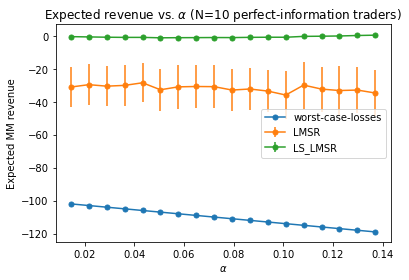

In [6]:
## Plot expected MM revenue vs alpha 
plt.plot(alphas, wcls, marker='o',markersize=5, label='worst-case-losses')
plt.errorbar(alphas, exprev_LMSR, yerr=exprev_stdevs_LMSR, marker='o',markersize=5, label='LMSR')
plt.errorbar(alphas, exprev_LS, yerr=exprev_stdevs_LS, marker='o',markersize=5, label='LS_LMSR')
plt.ylabel('Expected MM revenue')
plt.title(r'Expected revenue vs. $\alpha$ (N=10 perfect-information traders)')
plt.xlabel(r'$\alpha$')
plt.legend()
# plt.savefig('figs/exprevenuevsalpha.png')
plt.show()

## Plot final MM revenue vs alpha 
# plt.errorbar(alphas, rev_LS, yerr=rev_stdevs_LS, marker='o',markersize=5, label='LS_LMSR')
# plt.errorbar(alphas, rev_LMSR, yerr=rev_stdevs_LMSR, marker='o',markersize=5, label='LMSR')
# plt.plot(alphas, wcls, marker='o',markersize=5, label='worst-case-losses')
# plt.xlabel(r'$\alpha$')
# plt.ylabel(r'Final MM revenue')
# plt.title(r'Revenue vs. $\alpha$ (N=10 perfect-information traders)')
# plt.legend()
# plt.savefig('figs/revenuevsalpha.png')
# plt.close()


## Miscellaneous plotting
# plt.scatter(acc_LS, rev_LS, label='LS-LMSR')
# plt.scatter(acc_LMSR, rev_LMSR, label='LMSR')

# plt.plot(alphas, acc_LS, marker='o',label='LS_LMSR')
# plt.plot(alphas, acc_LMSR, marker='o', label='LMSR')
# plt.xlabel(r'$\alpha$')
# plt.ylabel(r'Final market prediction accuracy')
# plt.title(r'Market accuracy vs. $\alpha$ (N=10 perfect-information traders)')
# plt.legend()
# plt.savefig('figs/accuracyvsalpha.png')
# plt.close()

# print(alpha)

### Noisy information: run various simulations (different parameters) 

1. Run a simple noisy information simulation

In [7]:
s = Simulation()
ground_truth = s.draw_unif_ground_truth(0.6, 0.8)
init_quant = [100, 100]
alpha = 0.03
markets = s.create_market_comp(init_quant, 'LMSR', 'LSLMSR', s.compute_b(alpha, init_quant)[0], alpha, ground_truth)
# b1_prob, b2_prob, b1_exprev, b2_exprev = s.noisyinfo_sim(10, 10000000, markets, silence=False, verbose=False)
b1_prob, b2_prob, b1_exprev, b2_exprev = s.simple_noise_sim(10, 10000000, markets, verbose=True)
print()
print("LMSR price probabilities:", b1_prob)
print("LS-LMSR price probabilities:", b2_prob)
print("LMSR expected revenue:", b1_exprev)
print("LS-LMSR expected revenue:", b2_exprev)



GROUND TRUTH: [0.7295223035447839, 0.27047769645521613]
priv_info_noise: 0.2 ; look_back: 50 ; k: 0.5
INITIAL PRICE: LMSR [[0.5, 0.5]]
INITIAL PRICE: LS-LMSR [[0.5207944154167983, 0.5207944154167983]]

LMSR market trader 0 :
Cost of transaction 59.788207368956904
Expected final return after transaction 67.98994380572981
Current price vs beliefs [0.6641263976707303, 0.3358736023292696] [0.6636767323113553, 0.33632326768864473]
Final: bet: [102.44436861443745, 0.0] cost: 59.788207368956904
------
LS-LMSR market trader 0 :
Cost of transaction 2.1774003271961817
Expected final return after transaction 2.430289768146014
Current price vs beliefs [0.6650099821758326, 0.37400113253512957] [0.6636767323113553, 0.33632326768864473]
Final: bet: [3.661857723536819, 0.0] cost: 2.1774003271961817

LMSR market trader 1 :
Cost of transaction 0.6808525139211383
Expected final return after transaction 0.6838691025267102
Current price vs beliefs [0.6611241297951674, 0.3388758702048325] [0.6611315872023

2. Run noisy information simulation: indep variable =  alpha 

In [8]:
vigs = np.arange(0.02, 0.4, 0.02)
alphas = vigs/(2*np.log(2))

N_TRADERS = 20
init_quant = [100, 100]
N_TRIALS = 40
LOOK_BACK = int(N_TRADERS/4)
K = 0.3
K_MIN = 0.2
K_MAX = 0.6
PRIV_NOISE = 0.2

acc_LS = []
acc_quartiles_LS = []
acc_LMSR = []
acc_quartiles_LMSR = []
exprev_LMSR = []
exprev_quartiles_LMSR = []
exprev_LS = []
exprev_quartiles_LS = []

wcls= [] # worst-case losses 

for alpha in alphas:
    s = Simulation()
    acc_LS_temp = []
    acc_LMSR_temp = []
    exprev_LMSR_temp = []
    exprev_LS_temp = []

    b, worst_case_loss = s.compute_b(alpha, init_quant)
    # print(b, worst_case_loss)
    wcls.append(-worst_case_loss)

    for i in range(N_TRIALS):
        #### SET HYPERPARAMETER
        ground_truth = s.draw_unif_ground_truth(0.6, 0.8)
        #### 
        markets = s.create_market_comp([100, 100], 'LMSR', 'LSLMSR', b, alpha, ground_truth)
        b1, b2 = markets[0], markets[1]
        b1_prob, b2_prob, b1_exprev, b2_exprev = s.simple_noise_sim(N_TRADERS, 10000000, markets, priv_info_noise=PRIV_NOISE,look_back=LOOK_BACK, k_min=K_MIN, k_max=K_MAX, silence=True, verbose=False)
        # b1_prob, b2_prob, b1_exprev, b2_exprev = s.noisyinfo_sim(N_TRADERS, 10000000, markets, p_signal_low=0.2, p_signal_high=0.8, silence=True, verbose=False)
        acc_LS_temp.append(1-abs(b2_prob[0]-ground_truth[0]))
        acc_LMSR_temp.append(1-abs(b1_prob[0]-ground_truth[0]))
        exprev_LS_temp.append(b2_exprev)
        exprev_LMSR_temp.append(b1_exprev)
    
    acc_LMSR.append(np.median(acc_LMSR_temp))
    acc_LS.append(np.median(acc_LS_temp))
    exprev_LMSR.append(np.median(exprev_LMSR_temp))
    exprev_LS.append(np.median(exprev_LS_temp))
    acc_quartiles_LMSR.append([np.median(acc_LMSR_temp)-np.quantile(acc_LMSR_temp, 0.25), np.quantile(acc_LMSR_temp, 0.75)-np.median(acc_LMSR_temp)])
    acc_quartiles_LS.append([np.median(acc_LS_temp)-np.quantile(acc_LS_temp, 0.25), np.quantile(acc_LS_temp, 0.75)-np.median(acc_LS_temp)])
    exprev_quartiles_LMSR.append([np.median(exprev_LMSR_temp)-np.quantile(exprev_LMSR_temp, 0.25), np.quantile(exprev_LMSR_temp, 0.75)-np.median(exprev_LMSR_temp)])
    exprev_quartiles_LS.append([np.median(exprev_LS_temp)-np.quantile(exprev_LS_temp, 0.25), np.quantile(exprev_LS_temp, 0.75)-np.median(exprev_LS_temp)])

    # acc_LS.append(np.mean(acc_LS_temp))
    # acc_LMSR.append(np.mean(acc_LMSR_temp))
    # exprev_LMSR.append(np.mean(exprev_LMSR_temp))
    # exprev_stdevs_LMSR.append(np.std(exprev_LMSR_temp))
    # exprev_LS.append(np.mean(exprev_LS_temp))
    # exprev_stdevs_LS.append(np.std(exprev_LS_temp))

exprev_quartiles_LMSR = [[exprev_quartiles_LMSR[i][0] for i in range(len(alphas))], [exprev_quartiles_LMSR[i][1] for i in range(len(alphas))]] 
exprev_quartiles_LS = [[exprev_quartiles_LS[i][0] for i in range(len(alphas))], [exprev_quartiles_LS[i][1] for i in range(len(alphas))]] 
acc_quartiles_LMSR = [[acc_quartiles_LMSR[i][0] for i in range(len(alphas))], [acc_quartiles_LMSR[i][1] for i in range(len(alphas))]] 
acc_quartiles_LS = [[acc_quartiles_LS[i][0] for i in range(len(alphas))], [acc_quartiles_LS[i][1] for i in range(len(alphas))]] 

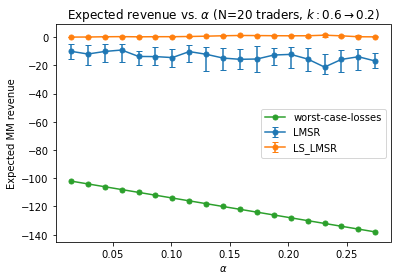

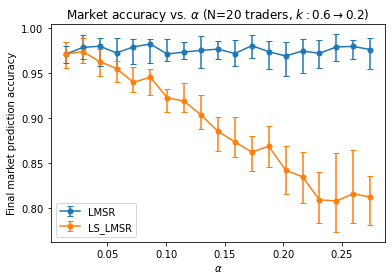

In [12]:
## Plot results

## A. EXP REV vs ALPHA 
# plt.errorbar(alphas, exprev_LMSR, yerr=exprev_stdevs_LMSR, marker='o',markersize=5, label='LMSR')
# plt.errorbar(alphas, exprev_LS, yerr=exprev_stdevs_LS, marker='o',markersize=5, label='LS_LMSR')
## note: this plots MEDIANS and 1st / 3rd quartile
plt.errorbar(alphas, exprev_LMSR, yerr=exprev_quartiles_LMSR, marker='o',markersize=5, capsize=3, label='LMSR')
plt.errorbar(alphas, exprev_LS, yerr=exprev_quartiles_LS, marker='o',markersize=5, capsize=3, label='LS_LMSR')
plt.plot(alphas, wcls, marker='o',markersize=5, label='worst-case-losses')
plt.ylabel('Expected MM revenue')
plt.title(r'Expected revenue vs. $\alpha$ (N=20 traders, $k: 0.6 \rightarrow 0.2$)')
plt.xlabel(r'$\alpha$')
plt.legend()
# plt.savefig('figs/simple_noise_exprev_alpha.png')
plt.show()

## B. ACCURACY vs ALPHA 
# plt.plot(alphas, acc_LS, marker='o',label='LS_LMSR')
# plt.plot(alphas, acc_LMSR, marker='o', label='LMSR')
## note: this plots MEDIANS and 1st / 3rd quartile
plt.errorbar(alphas, acc_LMSR, yerr=acc_quartiles_LMSR, marker='o',markersize=5, capsize=3, label='LMSR')
plt.errorbar(alphas, acc_LS, yerr=acc_quartiles_LS, marker='o',markersize=5, capsize=3, label='LS_LMSR')
plt.xlabel(r'$\alpha$')
plt.ylabel(r'Final market prediction accuracy')
plt.title(r'Market accuracy vs. $\alpha$ (N=20 traders, $k: 0.6 \rightarrow 0.2$)')
plt.legend()
# plt.savefig('figs/simple_noise_acc_alpha.png')
plt.show()

## C. EXP REV vs ACCURACY (deprecated -- see Janum's code for plotting this instead)
# plt.plot(acc_LS, wcls, marker='o',markersize=5, label='worst-case-losses')
# plt.errorbar(acc_LMSR, exprev_LMSR, yerr=exprev_stdevs_LMSR, marker='o',markersize=5, label='LMSR')
# plt.errorbar(acc_LS, exprev_LS, yerr=exprev_stdevs_LS, marker='o',markersize=5, label='LS_LMSR')
# plt.ylabel('Expected MM revenue')
# plt.title(r'Expected revenue vs. price accuracy (N=20 traders in noise model)')
# plt.xlabel(r'Price accuracy')
# plt.legend()
# # plt.savefig('figs/noise2_exprev_accuracy.png')
# plt.show()

3. Run noisy information simulation: indep variable =  number of traders 

In [13]:
N_TRAD_MAX = 30
n_traders_arr = np.arange(1, N_TRAD_MAX)
init_quant = [100, 100]
alpha = 0.03
N_TRIALS = 40
LOOK_BACK = int(N_TRAD_MAX/4)
K = 0.3
K_MIN = 0.2
K_MAX = 0.6
PRIV_NOISE = 0.2

acc_LS = []
acc_LS_med = []
acc_quartiles_LS = []
acc_stdevs_LS = []

acc_LMSR = []
acc_LMSR_med = []
acc_quartiles_LMSR = []
acc_stdevs_LMSR = []

exprev_LS = []
exprev_LS_med = []
exprev_stdevs_LS = []

for nt in n_traders_arr:
    s = Simulation()
    b, worst_case_loss = s.compute_b(alpha, init_quant)
    acc_LS_temp = []
    acc_LMSR_temp = []
    exprev_LS_temp = []

    for i in range(N_TRIALS):
        #### SET HYPERPARAMETERS
        ground_truth = s.draw_unif_ground_truth(0.6, 0.8)
        #### 
        markets = s.create_market_comp([100, 100], 'LMSR', 'LSLMSR', b, alpha, ground_truth)
        b1, b2 = markets[0], markets[1]
        b1_prob, b2_prob, b1_exprev, b2_exprev = s.simple_noise_sim(nt, 10000000, markets, priv_info_noise=PRIV_NOISE,look_back=LOOK_BACK, k_min=K_MIN, k_max=K_MAX, silence=True, verbose=False)
        # b1_prob, b2_prob, b1_exprev, b2_exprev = s.simple_noise_sim(nt, 10000000, markets, priv_info_noise=0.2,look_back=LOOK_BACK,k=K, silence=True, verbose=False)
        # b1_prob, b2_prob, b1_exprev, b2_exprev = s.noisyinfo_sim(nt, 10000000, markets, priv_info_noise=0.3, p_signal_low=0.1, p_signal_high=0.9, silence=True, verbose=False)

        acc_LS_temp.append(1-abs(b2_prob[0]-ground_truth[0]))
        acc_LMSR_temp.append(1-abs(b1_prob[0]-ground_truth[0]))
        exprev_LS_temp.append(b2_exprev)

    acc_LS.append(np.mean(acc_LS_temp))
    acc_LS_med.append(np.median(acc_LS_temp))
    acc_stdevs_LS.append(np.std(acc_LS_temp))
    acc_quartiles_LS.append([np.median(acc_LS_temp)-np.quantile(acc_LS_temp, 0.25), np.quantile(acc_LS_temp, 0.75)-np.median(acc_LS_temp)])

    acc_LMSR.append(np.mean(acc_LMSR_temp))
    acc_LMSR_med.append(np.median(acc_LMSR_temp))
    acc_stdevs_LMSR.append(np.std(acc_LMSR_temp))
    acc_quartiles_LMSR.append([np.median(acc_LMSR_temp)-np.quantile(acc_LMSR_temp, 0.25), np.quantile(acc_LMSR_temp, 0.75)-np.median(acc_LMSR_temp)])

    exprev_LS.append(np.mean(exprev_LS_temp))
    exprev_LS_med.append(np.median(exprev_LS_temp))
    exprev_stdevs_LS.append(np.std(exprev_LS_temp))

In [ ]:
## Plot results

# 1. EXP REV vs NT 
plt.errorbar(n_traders_arr, exprev_LS, yerr=exprev_stdevs_LS, marker='o',markersize=5, label='LS_LMSR')
plt.ylabel('Expected MM revenue')
plt.title(r'Exp. revenue vs num. traders ($\alpha=0.03,k: 0.6 \rightarrow 0.2$)')
plt.xlabel(r'Number of traders')
plt.legend()
plt.savefig('figs/simple_noise_nt_exprev.png')
plt.show()

# 2. ACC vs NT
acc_quartiles_LMSR = [[acc_quartiles_LMSR[i][0] for i in range(len(n_traders_arr))], [acc_quartiles_LMSR[i][1] for i in range(len(n_traders_arr))]] 
acc_quartiles_LS = [[acc_quartiles_LS[i][0] for i in range(len(n_traders_arr))], [acc_quartiles_LS[i][1] for i in range(len(n_traders_arr))]] 

# plt.errorbar(n_traders_arr, acc_LS, yerr=acc_stdevs_LS, marker='o',markersize=5, label='LS_LMSR')
# plt.errorbar(n_traders_arr, acc_LMSR, yerr=acc_stdevs_LMSR, marker='o',markersize=5, label='LMSR')

# note: this plots MEDIANS and QUANTILES
plt.errorbar(n_traders_arr, acc_LMSR_med, yerr=acc_quartiles_LMSR, marker='o', markersize=5, capsize=3, label='LMSR')
plt.errorbar(n_traders_arr, acc_LS_med, yerr=acc_quartiles_LS, marker='o', markersize=5, capsize=3, label='LS-LMSR')
plt.ylabel('Final market prediction accuracy (median)')
plt.title(r'Market accuracy vs. num. traders ($\alpha=0.03,k: 0.6 \rightarrow 0.2$)')
plt.xlabel(r'Number of traders')
plt.legend()
plt.savefig('figs/simple_noise_nt_acc.png')
plt.show()